In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.fftpack import dct
from skimage.transform import rescale
from IPython.display import clear_output
from IPython import display

In [2]:
images_path = 'faces'

In [3]:
images = []
labels = []
for label, dir_name in enumerate(sorted(os.listdir(images_path))):
    dir_path = os.path.join(images_path, dir_name)
    for image_name in os.listdir(dir_path):
        image_path = os.path.join(dir_path, image_name)
        img = cv.imread(image_path, 0)
        images.append(img)
        labels.append(label)

In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
class BrightnessClassifier:
    """
        Классификатор на основе гистограммы яркости
    """
    def __init__(self, hist_size=256):
        self.hist_size = hist_size
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.train_histograms = []
        for train_image in self.X_train:
            train_hist = cv.calcHist([train_image], [0], None, [self.hist_size],[0,256])
            self.train_histograms.append(train_hist)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_hist = cv.calcHist([test_image], [0], None, [self.hist_size],[0,256])
            for train_hist in self.train_histograms:
                dist = np.linalg.norm(test_hist - train_hist)
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
            
        return np.array(predictions)
            

In [6]:
class DFTClassifier:
    """
        Классификатор на основе дискретного преобразования Фурье
    """
    def __init__(self, size=1.0):
        self.size = size
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.max_row = int(X_train[0].shape[0]*self.size)
        self.max_column = int(X_train[0].shape[1]*self.size)
        self.train_dfts = []
        for train_image in self.X_train:
            train_dft = np.fft.fft2(train_image)
            train_dft = np.fft.fftshift(train_dft)
            train_dft = 20*np.log(np.abs(train_dft))
            train_dft = train_dft[:self.max_row, :self.max_column]    
            self.train_dfts.append(train_dft)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_dft = np.fft.fft2(test_image)
            test_dft = np.fft.fftshift(test_dft)
            test_dft = 20*np.log(np.abs(test_dft))
            test_dft = test_dft[:self.max_row, :self.max_column]
            for train_dft in self.train_dfts:
                dist = np.linalg.norm(test_dft.ravel() - train_dft.ravel())
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)     
            
        return np.array(predictions)

In [7]:
class DCTClassifier:
    """
        Классификатор на основе дискретного косинусного преобразования
        @param: float size: Использует прямоугольник размером size*row и size*columns от всего изображения
    """
    def __init__(self, size=1.0):
        self.size = size
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.max_row = int(X_train[0].shape[0]*self.size)
        self.max_column = int(X_train[0].shape[1]*self.size)
        self.train_dcts = []
        for train_image in self.X_train:
            train_dct = dct(dct(train_image.T, norm='ortho').T, norm='ortho')
            train_dct = train_dct[:self.max_row, :self.max_column]
            self.train_dcts.append(train_dct)    
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_dct = dct(dct(test_image.T, norm='ortho').T, norm='ortho')
            test_dct = test_dct[:self.max_row, :self.max_column]
            for train_dct in self.train_dcts:
                dist = np.linalg.norm(train_dct.ravel() - test_dct.ravel())
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
        
        return np.array(predictions)

In [8]:
class ScaleClassifier:
    """
        Классификатор на основе масштабирования
        @param array-like sizes: Представляет собой массив масштабов
    """
    def __init__(self, sizes=[1.0]):
        self.sizes = sizes
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.train_rescaled_imgs = []
        for train_image in self.X_train:
            rescaled = self.get_rescaled_imgs(train_image)
            self.train_rescaled_imgs.append(rescaled)
    
    def get_rescaled_imgs(self, img):
        rescaled_imgs = []
        for size in self.sizes:   
            rescaled_img = rescale(img, size, mode='constant', anti_aliasing=False, multichannel=False)
            rescaled_imgs.append(rescaled_img)
        return rescaled_imgs       
    
    def get_avg_distance(self, rescaled_img1, rescaled_img2):
        total_dist = 0
        for i in range(len(self.sizes)):
            total_dist += np.linalg.norm(rescaled_img1[i].ravel() - rescaled_img2[i].ravel())
        
        return total_dist / len(self.sizes)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_rescaled_img = self.get_rescaled_imgs(test_image)
            for train_rescaled_img in self.train_rescaled_imgs:
                dist = self.get_avg_distance(test_rescaled_img, train_rescaled_img)
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
            
        return np.array(predictions)   

In [9]:
class GradientClassifier:
    """
        Классификатор на основе градиента
        @param: int ksize: Размер ядра
    """
    def __init__(self, ksize=-1):
        self.ksize = ksize
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train= y_train
        self.train_gradients = []
        for train_image in self.X_train:
            train_grad = cv.Sobel(train_image, cv.CV_64F, 0, 1, ksize=self.ksize)
            self.train_gradients.append(train_grad)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_grad = cv.Sobel(test_image, cv.CV_64F, 0, 1, ksize=self.ksize)
            for train_grad in self.train_gradients:
                dist = np.linalg.norm(test_grad.ravel() - train_grad.ravel())
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
        
        return np.array(predictions)

In [10]:
class VotingClassifier:
    """
        Классификатор основанный на правиле большинства
    """
    def __init__(self, estimators, voting='hard'):
        self.estimators = estimators
        self.voting = voting
        
    def fit(self, X_train, y_train):
        for estimator in self.estimators:
            estimator.fit(X_train, y_train)
    
    def predict(self, X_test):
        predictions = []
        for estimator in self.estimators:
            y_pred = estimator.predict(X_test)
            predictions.append(y_pred)
        predictions = np.array(predictions)
        predictions = np.apply_along_axis(lambda x: np.bincount(x, minlength=40), 0, predictions).argmax(axis=0)
        return predictions

In [11]:
def accuracy_score(y_pred, y_test):
    return sum(y_pred == y_test) / len(y_test)

In [12]:
def plot_test_acc(test_sizes, accuracies, clf_name):
    plt.plot(test_sizes, accuracies)
    plt.xlabel('test_size')
    plt.ylabel('accuracy')
    plt.title(clf_name)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=len(np.unique(labels)), 
                                                    random_state=25, stratify=labels)

# Тестирование на обучающей выборке

## Гистограмма яркости

In [14]:
brightness_clf = BrightnessClassifier()

In [15]:
brightness_clf.fit(X_train, y_train)

In [16]:
%%time
y_pred = brightness_clf.predict(X_train)

Wall time: 719 ms


In [17]:
accuracy_score(y_pred, y_train)

1.0

## Дискретное преобразование Фурье

In [18]:
dft_clf = DFTClassifier()

In [19]:
dft_clf.fit(X_train, y_train)

In [20]:
%%time
y_pred = dft_clf.predict(X_train)

Wall time: 7.88 s


In [21]:
accuracy_score(y_pred, y_train)

1.0

## Дискретное косинусное преобразование

In [22]:
dct_clf = DCTClassifier()

In [23]:
dct_clf.fit(X_train, y_train)

In [24]:
%%time
y_pred = dct_clf.predict(X_train)

Wall time: 3.36 s


In [25]:
accuracy_score(y_pred, y_train)

1.0

## Масштабирование

In [26]:
scale_clf = ScaleClassifier(sizes=[1.0, 0.9, 0.8, 0.5])

In [27]:
%%time
scale_clf.fit(X_train, y_train)

Wall time: 1.61 s


In [28]:
%%time
y_pred = scale_clf.predict(X_train)

Wall time: 11.1 s


In [29]:
accuracy_score(y_pred, y_train)

1.0

## Градиент

In [30]:
gradient_clf = GradientClassifier()

In [31]:
gradient_clf.fit(X_train, y_train)

In [32]:
%%time
y_pred = gradient_clf.predict(X_train)

Wall time: 3.03 s


In [33]:
accuracy_score(y_pred, y_train)

1.0

# Тестирование на тестовой выборке

## Гистограмма яркости

**Классификация с параметром по умолчанию `size=256`**

In [34]:
brightness_clf = BrightnessClassifier()

In [35]:
brightness_clf.fit(X_train, y_train)

In [36]:
%%time
y_pred = brightness_clf.predict(X_test)

Wall time: 78.1 ms


In [37]:
accuracy_score(y_pred, y_test)

1.0

**Классификация с параметром `size` в диапазоне [3..256]**

In [38]:
%%time
accuracies = []
for size in range(3, 257):
    brightness_clf = BrightnessClassifier(hist_size=size)
    brightness_clf.fit(X_train, y_train)
    y_pred = brightness_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

Wall time: 20.4 s


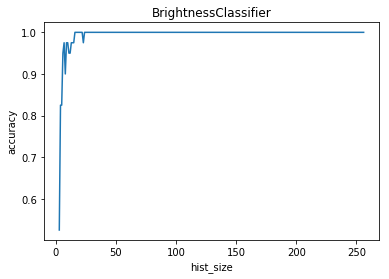

In [39]:
plt.plot(range(3, 257), accuracies)
plt.xlabel('hist_size')
plt.ylabel('accuracy')
plt.title('BrightnessClassifier');

In [40]:
print('Оптимальный параметр size:', np.arange(3, 257, 1)[np.argmax(accuracies)])
print('Точность:', max(accuracies))

Оптимальный параметр size: 16
Точность: 1.0


## Дискретное преобразование Фурье

**Классификация с параметром по умолчанию `size=1.0`**

In [41]:
dft_clf = DFTClassifier()

In [42]:
dft_clf.fit(X_train, y_train)

In [43]:
%%time
y_pred = dft_clf.predict(X_test)

Wall time: 797 ms


In [44]:
accuracy_score(y_pred, y_test)

0.9

**Клссификация с параметром `size` в диапазоне [0.1..1.0]**

In [45]:
%%time
accuracies = []
for size in np.arange(0.1, 1.05, 0.05):
    dft_clf = DFTClassifier(size=size)
    dft_clf.fit(X_train, y_train)
    y_pred = dft_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

Wall time: 14.9 s


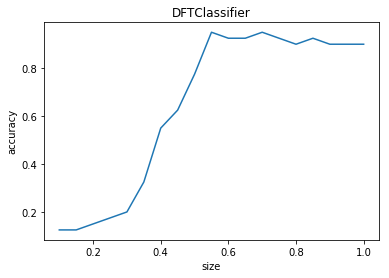

In [46]:
plt.plot(np.arange(0.1, 1.05, 0.05), accuracies)
plt.xlabel('size')
plt.ylabel('accuracy')
plt.title('DFTClassifier');

In [47]:
print('Оптимальный параметр size:', np.arange(0.1, 1.05, 0.05)[np.argmax(accuracies)])
print('Точность:', max(accuracies))

Оптимальный параметр size: 0.5500000000000002
Точность: 0.95


## Дискретное косинусное преобразование

**Классификация с параметром по умолчанию `size=1.0`**

In [48]:
dct_clf = DCTClassifier()

In [49]:
dct_clf.fit(X_train, y_train)

In [50]:
%%time
y_pred = dct_clf.predict(X_test)

Wall time: 584 ms


In [51]:
accuracy_score(y_pred, y_test)

0.975

**Клссификация с параметром `size` в диапазоне [0.1..1.0]**

In [52]:
%%time
accuracies = []
for size in np.arange(0.1, 1.05, 0.05):
    dct_clf = DCTClassifier(size=size)
    dct_clf.fit(X_train, y_train)
    y_pred = dct_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

Wall time: 8.98 s


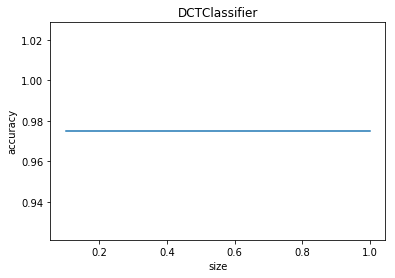

In [53]:
plt.plot(np.arange(0.1, 1.05, 0.05), accuracies)
plt.xlabel('size')
plt.ylabel('accuracy')
plt.title('DCTClassifier');

In [54]:
print('Оптимальный параметр size:', np.arange(0.1, 1.05, 0.05)[np.argmax(accuracies)])
print('Точность:', max(accuracies))

Оптимальный параметр size: 0.1
Точность: 0.975


## Масштабирование

In [55]:
scale_clf = ScaleClassifier(sizes=[0.1, 0.5, 0.8])

In [56]:
%%time
scale_clf.fit(X_train, y_train)

Wall time: 859 ms


In [57]:
%%time
y_pred = scale_clf.predict(X_test)

Wall time: 625 ms


In [58]:
accuracy_score(y_pred, y_test)

1.0

**Классификация с параметром `sizes` в диапазоне [0.05..1.0]**

In [59]:
%%time
accuracies = []
for size in np.arange(0.05, 1.05, 0.05):
    scale_clf = ScaleClassifier(sizes=[size])
    scale_clf.fit(X_train, y_train)
    y_pred = scale_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

Wall time: 12.3 s


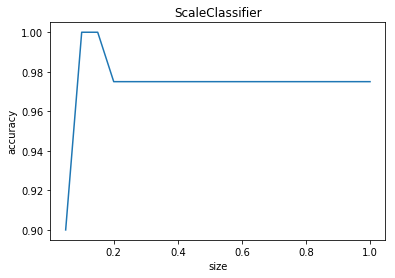

In [60]:
plt.plot(np.arange(0.05, 1.05, 0.05), accuracies)
plt.xlabel('size')
plt.ylabel('accuracy')
plt.title('ScaleClassifier');

**Классификация с параметром `sizes` в диапазоне [0.05..1.0].    
Предыдущие параметры на каждой итерации не удаляются**

In [61]:
%%time
accuracies = []
sizes = []
for size in np.arange(0.05, 1.05, 0.05):
    sizes.append(size)
    scale_clf = ScaleClassifier(sizes=sizes)
    scale_clf.fit(X_train, y_train)
    y_pred = scale_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

Wall time: 1min 34s


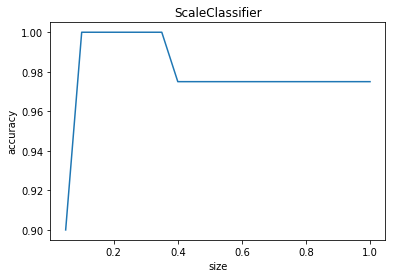

In [62]:
plt.plot(np.arange(0.05, 1.05, 0.05), accuracies)
plt.xlabel('size')
plt.ylabel('accuracy')
plt.title('ScaleClassifier');

In [63]:
print('Оптимальный набор параметров:', sizes[:np.argmax(accuracies) + 1])
print('Точность:', np.max(accuracies))

Оптимальный набор параметров: [0.05, 0.1]
Точность: 1.0


## Градиент

**Классификация с параметром по умолчанию `ksize=-1`.    
В этом случае используется `3x3 Scharr` фильтер.**

In [64]:
gradient_clf = GradientClassifier()

In [65]:
gradient_clf.fit(X_train, y_train)

In [66]:
%%time
y_pred = gradient_clf.predict(X_test)

Wall time: 344 ms


In [67]:
accuracy_score(y_pred, y_test)

0.7

**Классификация с параметром `ksize` в диапазоне [3..31] с шагом 2** 

In [68]:
%%time
accuracies = []
for ksize in range(3, 31 + 1, 2):
    gradient_clf = GradientClassifier(ksize=ksize)
    gradient_clf.fit(X_train, y_train)
    y_pred = gradient_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

Wall time: 5.91 s


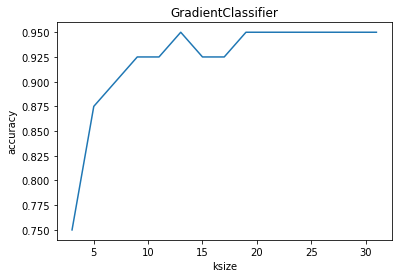

In [69]:
plt.plot(range(3, 31 + 1, 2), accuracies)
plt.xlabel('ksize')
plt.ylabel('accuracy')
plt.title('GradientClassifier');

In [70]:
print('Оптимальный параметр ksize:', list(range(3, 32, 2))[np.argmax(accuracies)])
print('Точность:', max(accuracies))

Оптимальный параметр ksize: 13
Точность: 0.95


# Кросс-Валидация исходных данных

In [71]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

In [72]:
%%time
bright_cv_scores = []
dft_cv_scores = []
dct_cv_scores = []
scale_cv_scores = []
grad_cv_scores = []
for i, (train_idx, test_idx) in enumerate(skf.split(images, labels), start=1):
    clear_output(wait=True)
    print(i)
    X_train, y_train = images[train_idx], labels[train_idx]
    X_test, y_test = images[test_idx], labels[test_idx]

    brightness_clf = BrightnessClassifier()    
    brightness_clf.fit(X_train, y_train)
    y_pred = brightness_clf.predict(X_test)
    bright_cv_scores.append(accuracy_score(y_pred, y_test))
    
    dft_clf = DFTClassifier(size=0.55)
    dft_clf.fit(X_train, y_train)
    y_pred = dft_clf.predict(X_test)
    dft_cv_scores.append(accuracy_score(y_pred, y_test))
    
    dct_clf = DCTClassifier(size=0.1)
    dct_clf.fit(X_train, y_train)
    y_pred = dct_clf.predict(X_test)
    dct_cv_scores.append(accuracy_score(y_pred, y_test))
    
    scale_clf = ScaleClassifier(sizes=[0.05, 0.1, 0.15])
    scale_clf.fit(X_train, y_train)
    y_pred = scale_clf.predict(X_test)
    scale_cv_scores.append(accuracy_score(y_pred, y_test))
    
    gradient_clf = GradientClassifier(ksize=29)
    gradient_clf.fit(X_train, y_train)
    y_pred = gradient_clf.predict(X_test)
    grad_cv_scores.append(accuracy_score(y_pred, y_test))

10
Wall time: 26.5 s


In [73]:
print('BrightnessClassifier, точность на кросс-валидации:', np.mean(bright_cv_scores))
print('DFTClassifier, точность на кросс-валидации:', np.mean(dft_cv_scores))
print('DCTClassifier, точность на кросс-валидации:', np.mean(dct_cv_scores))
print('ScaleClassifier, точность на кросс-валидации:', np.mean(scale_cv_scores))
print('GradientClassifier, точность на кросс-валидации:', np.mean(grad_cv_scores))

BrightnessClassifier, точность на кросс-валидации: 0.9875
DFTClassifier, точность на кросс-валидации: 0.8799999999999999
DCTClassifier, точность на кросс-валидации: 0.9800000000000001
ScaleClassifier, точность на кросс-валидации: 0.9724999999999999
GradientClassifier, точность на кросс-валидации: 0.9375


## Зависимости распознавания от числа тестовых изображений в выборке

In [74]:
%%time
bright_scores = []
dft_scores = []
dct_scores = []
scale_scores = []
grad_scores = []
for i, test_size in enumerate(range(40, 170, 10), start=1):
    clear_output(wait=True)
    print(f'Iteration {i} from {len(range(40, 170, 10))}')
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, 
                                                        random_state=25, stratify=labels)
    brightness_clf = BrightnessClassifier()    
    brightness_clf.fit(X_train, y_train)
    y_pred = brightness_clf.predict(X_test)
    bright_scores.append(accuracy_score(y_pred, y_test))
    
    dft_clf = DFTClassifier(size=0.55)
    dft_clf.fit(X_train, y_train)
    y_pred = dft_clf.predict(X_test)
    dft_scores.append(accuracy_score(y_pred, y_test))
    
    dct_clf = DCTClassifier(size=0.1)
    dct_clf.fit(X_train, y_train)
    y_pred = dct_clf.predict(X_test)
    dct_scores.append(accuracy_score(y_pred, y_test))
    
    scale_clf = ScaleClassifier(sizes=[0.05, 0.1, 0.15])
    scale_clf.fit(X_train, y_train)
    y_pred = scale_clf.predict(X_test)
    scale_scores.append(accuracy_score(y_pred, y_test))
    
    gradient_clf = GradientClassifier(ksize=29)
    gradient_clf.fit(X_train, y_train)
    y_pred = gradient_clf.predict(X_test)
    grad_scores.append(accuracy_score(y_pred, y_test))

Iteration 13 from 13
Wall time: 49.6 s


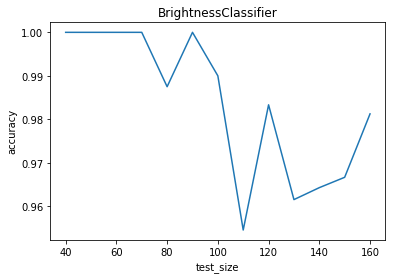

In [75]:
plot_test_acc(range(40, 170, 10), bright_scores, 'BrightnessClassifier')

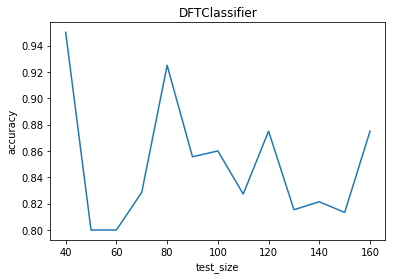

In [76]:
plot_test_acc(range(40, 170, 10), dft_scores, 'DFTClassifier')

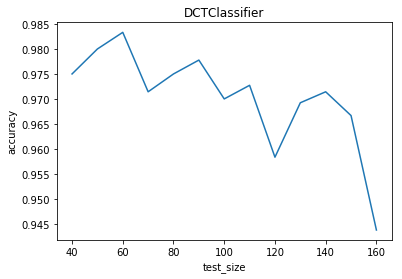

In [77]:
plot_test_acc(range(40, 170, 10), dct_scores, 'DCTClassifier')

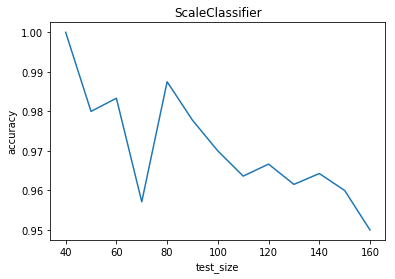

In [78]:
plot_test_acc(range(40, 170, 10), scale_scores, 'ScaleClassifier')

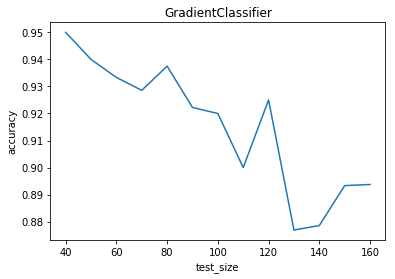

In [79]:
plot_test_acc(range(40, 170, 10), grad_scores, 'GradientClassifier')

## Визуализация изображений

In [80]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=len(np.unique(labels)), 
                                                    random_state=25, stratify=labels)

In [81]:
brightness_clf = BrightnessClassifier()    
brightness_clf.fit(X_train, y_train)
y_pred_bright = brightness_clf.predict(X_test)

dft_clf = DFTClassifier()
dft_clf.fit(X_train, y_train)
y_pred_dft = dft_clf.predict(X_test)

dct_clf = DCTClassifier()
dct_clf.fit(X_train, y_train)
y_pred_dct = dct_clf.predict(X_test)

scale_clf = ScaleClassifier()
scale_clf.fit(X_train, y_train)
y_pred_scale = scale_clf.predict(X_test)

gradient_clf = GradientClassifier()
gradient_clf.fit(X_train, y_train)
y_pred_grad = gradient_clf.predict(X_test)

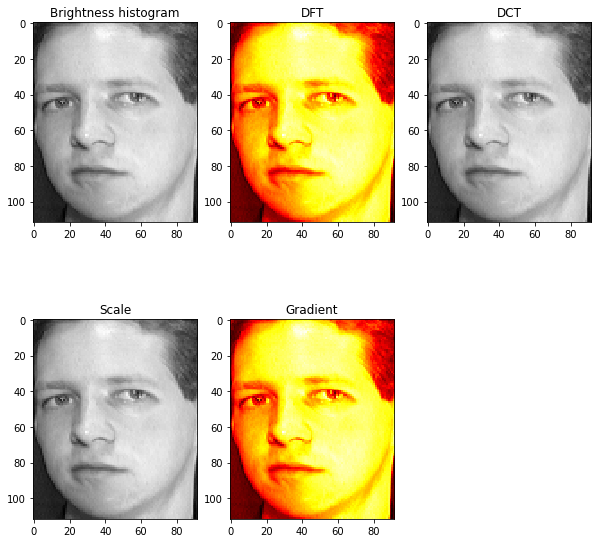

In [82]:
fig = plt.figure(figsize=(10,10))
for i, (true_label, img) in enumerate(zip(y_test, X_test)):
    fig.add_subplot(2, 3, 1)
    if true_label == y_pred_bright[i]:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img, cmap="hot")
    plt.title("Brightness histogram")
   
    fig.add_subplot(2, 3, 2)
    if true_label == y_pred_dft[i]:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img, cmap="hot")
    plt.title("DFT")
    
    fig.add_subplot(2, 3, 3)  
    if true_label == y_pred_dct[i]:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img, cmap="hot")
    plt.title("DCT")
    
    fig.add_subplot(2, 3, 4)
    if true_label == y_pred_scale[i]:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img, cmap="hot")
    plt.title("Scale")
    
    fig.add_subplot(2, 3, 5)
    if true_label == y_pred_grad[i]:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img, cmap="hot")
    plt.title("Gradient")
    
    time.sleep(1)
    display.display(plt.gcf())
    clear_output(wait=True)

# Классификация по принципу голосования

**Классификация с параметрами по умолчанию**

In [83]:
estimators = [BrightnessClassifier(), DFTClassifier(), DCTClassifier(), 
              ScaleClassifier(sizes=[0.5]), GradientClassifier(ksize=3)]
voting_classifier = VotingClassifier(estimators=estimators)

In [84]:
voting_classifier.fit(X_train, y_train)

In [85]:
%%time
y_pred = voting_classifier.predict(X_test)

Wall time: 1.95 s


In [86]:
accuracy_score(y_pred, y_test)

0.975

**Классификация с оптимальными параметрами для каждого классификатора**

In [87]:
estimators = [BrightnessClassifier(hist_size=256), DFTClassifier(size=0.55), DCTClassifier(size=0.1), 
              ScaleClassifier(sizes=[0.05, 0.1, 0.15]), GradientClassifier(ksize=29)]
voting_classifier = VotingClassifier(estimators=estimators)

In [88]:
voting_classifier.fit(X_train, y_train)

In [89]:
%%time
y_pred = voting_classifier.predict(X_test)

Wall time: 1.34 s


In [90]:
accuracy_score(y_pred, y_test)

0.975

**Зависимость распознавания от числа тестовых изображений в выборке**

In [91]:
%%time
scores = []
for i, test_size in enumerate(range(40, 210, 10), start=1):
    clear_output(wait=True)
    print(f'Iteration {i} from {len(range(40, 210, 10))}')
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, 
                                                        random_state=25, stratify=labels)
    
    estimators = [BrightnessClassifier(hist_size=256), DFTClassifier(size=0.55), DCTClassifier(size=0.1), 
                  ScaleClassifier(sizes=[0.05, 0.1, 0.15]), GradientClassifier(ksize=29)]
    voting_classifier = VotingClassifier(estimators=estimators)
    voting_classifier.fit(X_train, y_train)
    y_pred = voting_classifier.predict(X_test)
    scores.append(accuracy_score(y_pred, y_test))

Iteration 17 from 17
Wall time: 1min 9s


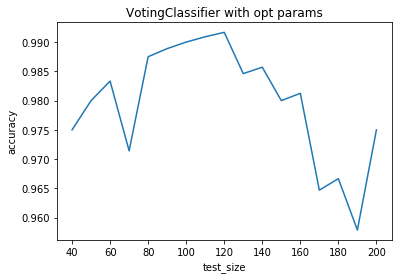

In [92]:
plot_test_acc(range(40, 210, 10), scores, 'VotingClassifier with opt params')

**Кросс-валидация**

In [93]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

In [94]:
%%time
cv_scores = []
for i, (train_idx, test_idx) in enumerate(skf.split(images, labels), start=1):
    clear_output(wait=True)
    print(i)
    X_train, y_train = images[train_idx], labels[train_idx]
    X_test, y_test = images[test_idx], labels[test_idx]

    estimators = [BrightnessClassifier(hist_size=256), DFTClassifier(size=0.55), DCTClassifier(size=0.1), 
                  ScaleClassifier(sizes=[0.05, 0.1, 0.15]), GradientClassifier(ksize=29)]
    voting_classifier = VotingClassifier(estimators=estimators)
    voting_classifier.fit(X_train, y_train)
    y_pred = voting_classifier.predict(X_test)
    cv_scores.append(accuracy_score(y_pred, y_test))

print('Точность на кросс-валидации:', np.mean(cv_scores))

10
Точность на кросс-валидации: 0.99
Wall time: 26.9 s
